In [275]:
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [276]:
import getpass
import os
os.environ["LANGCHAIN_PROJECT"] = "RAG-with-website"
os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

··········


In [277]:
pip install -qU "langchain[openai]"

In [278]:
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [279]:
pip install -qU langchain-openai

In [280]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [281]:
pip install -qU langchain-core


In [282]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [283]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [284]:
from langchain.document_loaders.recursive_url_loader import RecursiveUrlLoader

In [285]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# SoupStrainer is a filter


loader = WebBaseLoader(
    web_paths=("https://durhamcollege.ca/",),
)
docs = loader.load()

assert len(docs) == 1 # check to see if docs is one document - should be otherwise throw an error

#if we're here, document is correct (length is one)
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 12941


In [ ]:
#print first 500 characters - sanity check
print(docs[0].page_content[5000:8000])

In [287]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Splot website to {len(all_splits)} sub-documents.")

Splot website to 17 sub-documents.


In [288]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['2ca52508-15c5-4c19-87a0-22063af83ff8', '689957f9-9e78-4334-9efd-9239df949129', '47074f74-9c75-47e3-9d06-188a9c966b79']


In [289]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [290]:
#custom prompt
from langchain_core.prompts import PromptTemplate

template = """ Answer the question based on the following context ONLY.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

The State is a concept in LangGraph
It suppose to hold important data that you expect would be useful for your RAG (and later Agent)
To be flexible, States are made to be dictionaries (key, value) sets

In [291]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# Creating a class called State which inherits from TypeDict
# TypeDict is a Dictionary class ==> key: value
# The purpose of this Class is really to create a dictionary with a specific structure
# Dictionaries in python do not have a rigid structure, with this structure you can enforce a specific structure
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Nodes
Nodes in LangGraph are just python functions

Each node always gets a State and does something with it

Remember, functions in python have form

def function_name(input_params) -> return_type:


In [292]:
from typing import Dict, List
from langchain_core.documents import Document

def retrieve_node(state: State) -> Dict[str, List[Document]]:
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate_node(state: State)-> Dict[str, str]:
    #Make all the documents into a single string.
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Control flow and Adding Edges

Edges are how you connect nodes.  

Here it's pretty simple, retrieve node needs to be connected to question node and we need to have the input connect to the retrieve

LangGraph allows you to do this with a "graph" object

Think of StateGraph as your who system (you can add to it as you go along, don't need to get it up in one shot)



In [293]:
from langgraph.graph import START, StateGraph

rag = StateGraph(State).add_sequence([retrieve_node, generate_node])


Every state needs a starting point, so we add this edge to the graph object rag

In [294]:
rag.add_edge(START, "retrieve_node")

We now need a "binary".  We need to be able to call our graph.  So this is what this line does

In [301]:
rag_binary = rag.compile()

See the graph

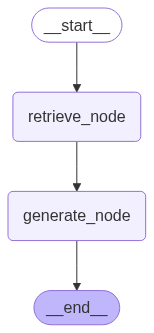

In [296]:
from IPython.display import Image, display

display(Image(rag_binary.get_graph().draw_mermaid_png()))

# Using the rag Graph

In [302]:
result = rag_binary.invoke({"question": "When is Navigating DC connect workshop?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='d7c6d42e-e543-4fab-884b-db7c52ed4ee4', metadata={'source': 'https://durhamcollege.ca/', 'title': 'Durham College - Oshawa, Ontario, Canada', 'description': 'Durham College is the premier post-secondary destination for students to succeed in a dynamic and supportive learning environment. Our graduates develop the professional and personal skills needed to realize meaningful careers and make a difference in the world.', 'language': 'en-US', 'start_index': 9460}, page_content="Important Dates\n\n\n\n\n\n\n\n\n\n                                May.\n                            \n\n\n\n                                23                            \n\n\n\n\nAcademic \n\n\nNavigating DC Connect Workshop \n\n\n\n\n\n\n\n\n\n\n                                May.\n                            \n\n\n\n                                26                            \n\n\n\n\nFuture Students \n\n\nGraduate Certificates Webinar \n\n\n\n\n\n\n\n\n\n\n                             

In [303]:
for step in rag_binary.stream(
    {"question": "When is Navigating DC connect workshop?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve_node': {'context': [Document(id='d7c6d42e-e543-4fab-884b-db7c52ed4ee4', metadata={'source': 'https://durhamcollege.ca/', 'title': 'Durham College - Oshawa, Ontario, Canada', 'description': 'Durham College is the premier post-secondary destination for students to succeed in a dynamic and supportive learning environment. Our graduates develop the professional and personal skills needed to realize meaningful careers and make a difference in the world.', 'language': 'en-US', 'start_index': 9460}, page_content="Important Dates\n\n\n\n\n\n\n\n\n\n                                May.\n                            \n\n\n\n                                23                            \n\n\n\n\nAcademic \n\n\nNavigating DC Connect Workshop \n\n\n\n\n\n\n\n\n\n\n                                May.\n                            \n\n\n\n                                26                            \n\n\n\n\nFuture Students \n\n\nGraduate Certificates Webinar \n\n\n\n\n\n\n\n\n\n\n        

In [299]:
for message, metadata in rag_binary.stream(
    {"question": "What is the capital of Ontario?"}, stream_mode="messages"
):
    print(message.content, end="|")

|I| don't| know|.| Thanks| for| asking|!||